# Example of running level 2 processing steps

In this notebook, the following steps are perfromed:
- [Acquire, decimate, convert the data](#get)
- [Corrections](#corrections)
    - [Trend](#corrections)
    - [Tides](#tides)
    - [Atmospheric Pressure](#pressure)
    - [Offsets](#offsets)
    - [Regional Strain Conversion](#regionals)

In [110]:
# Import relevant modules from the earscopestraintools package
from earthscopestraintools.mseed_tools import ts_from_mseed
from earthscopestraintools.gtsm_metadata import GtsmMetadata
from earthscopestraintools.timeseries import plot_timeseries_comparison

# Allow logged output to be printed in the notebook as code cells are run
import logging
logger = logging.getLogger()
logging.basicConfig(
        format="%(message)s", level=logging.INFO
    )

## Acquire, decimate, convert the data from raw <a class="anchor" id="get"></a>

- Download 1hz raw data (in counts) from the IRIS/EarthScope DMC
  
    *This step also removes instrumental calibration pulses (999999 values in the raw data that occurr periodically).*
  
- Downsample to 300s

    *Applies a low-pass, minimum-phase finite impulse response filter (Hodgkinson and Agnew, 2007) prior to decimating the timeseries. Note that coseismic steps can not be relieably determined from the filtered data. Longer period signals are accurately represented.*
  
- Convert the data to microstrain

    *Raw data (in counts) represents a unit of electrical measurment from the gauge capacitance bridge, related to the diameter of the gauge. The raw data is converted to microstrain via linearization.*

**See the introductory materials for more information and further resources**

In [124]:
# define the network and station using FDSN seed codes ()
# then load the metadata for that station
network = 'IV' # e.g. PB = Plate Boundary Observatory, IV = I
station = 'TSM5' # available stations listed here https://www.unavco.org/data/strain-seismic/bsm-data/lib/docs/bsm_metadata.txt
meta = GtsmMetadata(network,station)
# Print the metadata contents
meta.show()

network: IV
fcid: TSM5
latitude: 43.479691
longitude: 12.60252
gap: 0.0001
orientation (CH0EofN): 342.9
reference strains:
 {'linear_date': '2022:154', 'CH0': 50858593, 'CH1': 53668101, 'CH2': 53904388, 'CH3': 49946112}
lab:
 [[ 0.2962963   0.51851852  0.2962963   0.22222222]
 [-0.23421081  0.3334514   0.10083025 -0.20007084]
 [-0.31429352 -0.1611967   0.3787722   0.09671802]]
ER2010:
 None
CH_prelim:
 [[-2.08608359 -2.03266363 -1.68423953 -0.55516656]
 [-0.17007719  0.21162844  0.28758364 -0.11504928]
 [-0.4530047  -0.43650645  0.00835573  0.03031218]]
atmp coefficients:
 {'CH0': -0.00679266, 'CH1': -0.00589221, 'CH2': -0.00567892, 'CH3': -0.00439148}
tidal params:
 {('CH0', 'M2', 'phz'): '26.48', ('CH0', 'M2', 'amp'): '15.702', ('CH0', 'M2', 'doodson'): '2 0 0 0 0 0', ('CH0', 'O1', 'phz'): '-167.131', ('CH0', 'O1', 'amp'): '3.373', ('CH0', 'O1', 'doodson'): '1-1 0 0 0 0', ('CH0', 'P1', 'phz'): '-166.546', ('CH0', 'P1', 'amp'): '7.298', ('CH0', 'P1', 'doodson'): '1 1-2 0 0 0', ('CH0',

IV TSM5 Loading T0 LS* from 2023-01-01T00:00:00 to 2023-01-10T00:00:00 from Earthscope DMC miniseed
    Trace 1. 2023-01-01T00:00:00.000000Z:2023-01-10T00:00:00.000000Z mapping LS1 to CH0
    Trace 2. 2023-01-01T00:00:00.000000Z:2023-01-10T00:00:00.000000Z mapping LS2 to CH1
    Trace 3. 2023-01-01T00:00:00.000000Z:2023-01-10T00:00:00.000000Z mapping LS3 to CH2
    Trace 4. 2023-01-01T00:00:00.000000Z:2023-01-10T00:00:00.000000Z mapping LS4 to CH3
    Found 0 epochs with nans, 5.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Converting missing data from 999999 to nan
  Converting 999999 values to nan
    Found 5 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
IV.TSM5.T0.LS*
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-01-01 00:00:00 - 2023-01-10 00:00:00        | Period:             1s
    | Series:         raw| Units:        counts| Level:          0| Gaps:             0.0% 

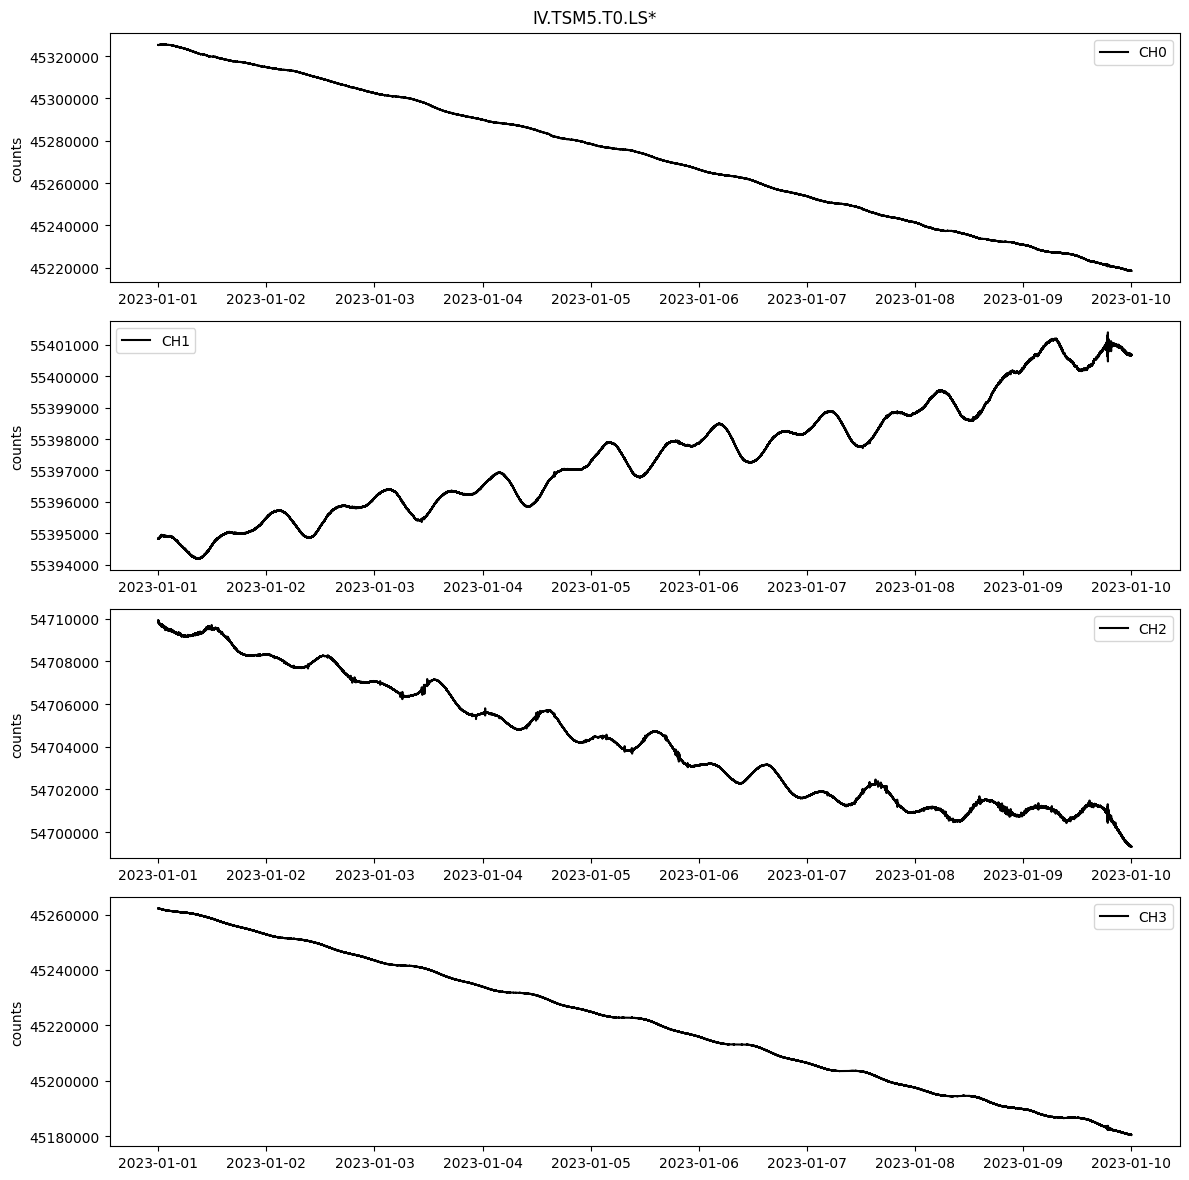

In [125]:
# Provide the start and end times for analysis
start="2023-01-01T00:00:00"
end = "2023-01-10T00:00:00"
# ts_from_mseed will load data into a earthscopestraintools.timeseres.Timeseries object via obspy and dataselect
# The location and channel codes follow SEED format
strain_raw = ts_from_mseed(network=network, station=station, location='T0', channel='LS*', start=start, end=end)
# Print some stats and plot the data
strain_raw.stats()
strain_raw.plot(type='line')

In [126]:
# Let's look at all available attributes and functions of strain_raw
# All classes and functions can be analyzed in this way
print('Attributes:\n',vars(strain_raw).keys())
functs = [func for func in dir(strain_raw) if callable(getattr(strain_raw,func)) and func.startswith('__') == False]
print('Functions:\n',functs)

Attributes:
 dict_keys(['data', 'columns', 'quality_df', 'series', 'units', 'level', 'period', 'network', 'station', 'name', 'nans', 'nines', 'epochs', 'gap_percentage'])
Functions:
 ['apply_calibration_matrix', 'apply_corrections', 'butterworth_filter', 'calculate_magnitude', 'calculate_offsets', 'calculate_pressure_correction', 'calculate_tide_correction', 'check_for_gaps', 'decimate_1s_to_300s', 'dynamic_strain', 'interpolate', 'linear_trend_correction', 'linearize', 'plot', 'remove_999999s', 'save_csv', 'set_data', 'set_initial_level_flags', 'set_initial_quality_flags', 'set_initial_version', 'set_local_tdb_uri', 'set_period', 'set_s3_tdb_uri', 'set_units', 'show_flagged_data', 'show_flags', 'stats']


In [127]:
# Use one of the functions to filter and decimate: calculate a 300s decimated Timeseries of raw counts
decimated_counts = strain_raw.decimate_1s_to_300s()
decimated_counts.data.head()

Decimating to 300s
Interpolating data using method=linear and limit=3600
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


,CH0,CH1,CH2,CH3
time,,,,
2023-01-01 00:00:00,45325335,55394828,54709901,45262210
2023-01-01 00:05:00,45325331,55394828,54709890,45262206
2023-01-01 00:10:00,45325300,55394830,54709843,45262174
2023-01-01 00:15:00,45325293,55394838,54709800,45262134
2023-01-01 00:20:00,45325327,55394852,54709768,45262104


Converting raw counts to microstrain
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
IV.TSM5.gauge.microstrain
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-01-01 00:00:00 - 2023-01-10 00:00:00        | Period:           300s
    | Series: microstrain| Units:   microstrain| Level:          1| Gaps:             0.0% 
    | Epochs:        2593| Good:        2592.25| Missing:      0.0| Interpolated:     0.75
    | Samples:      10372| Good:          10369| Missing:        0| Interpolated:        3


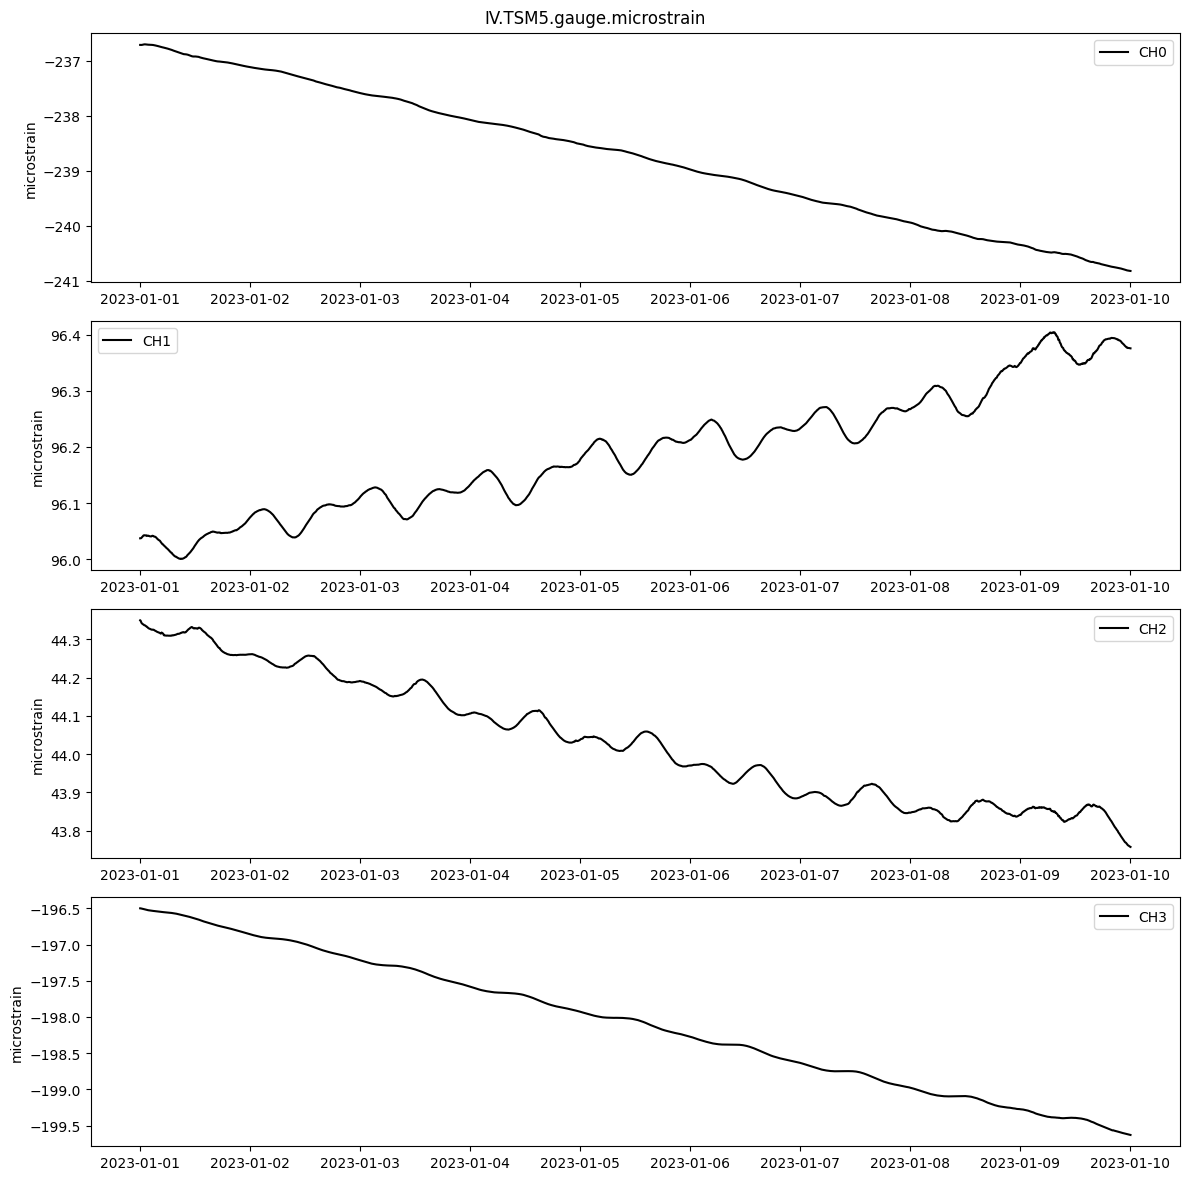

In [128]:
# Convert the raw counts into units of microstrain (1E-06)
name = f"{network}.{station}.gauge.microstrain" # Plot name
# The reference strains are standard values, but to zero to the first values of the time series, try: 
# reference_strains=decimated_counts.data.values[0]
gauge_microstrain = decimated_counts.linearize(reference_strains=meta.reference_strains, gap=meta.gap, name=name)
gauge_microstrain.stats()
gauge_microstrain.data.head()
gauge_microstrain.plot()

## Corrections <a class="anchor" id="corrections"></a>


### Trend <a class="anchor" id="corrections"></a>

A simple linear trend is calculated for this example to remove the long-term borehole relaxation signal. 

Calculating linear trend correction
    Trend Start: 2023-01-01 00:00:00
    Trend Start: 2023-01-10 00:00:00
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


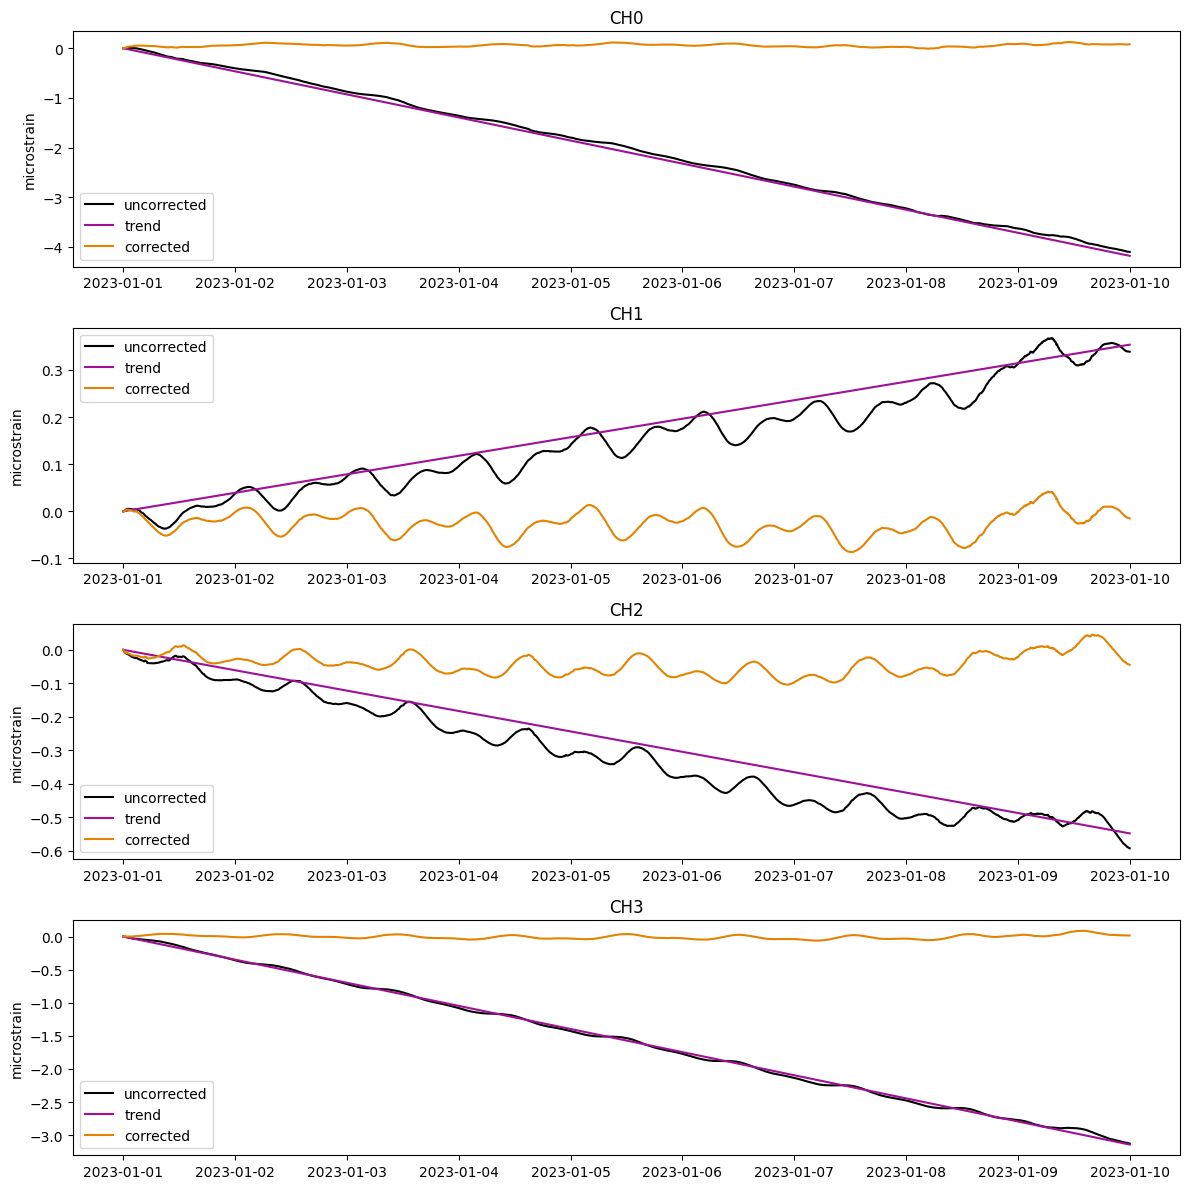

In [129]:
# calculate a linear trend correction and store it as a Timeseries
name = f"{network}.{station}.gauge.trend_c"
trend_c = gauge_microstrain.linear_trend_correction(name=name) # simple least squares trend 
# create a trend corrected Timeseries
corrected = gauge_microstrain.apply_corrections([trend_c])
# compare uncorrected, trend correction, and trend corrected Timeseries
plot_timeseries_comparison([gauge_microstrain, trend_c, corrected], names=['uncorrected', 'trend', 'corrected'], zero=True)

### Tides <a class="anchor" id="tides"></a>

The tidal amplitudes and phases for many of the largest tidal constituents (M2, O1, P1, K1, N2, S2) have been pre-determined for the stations in [BAYTAP08](https://igppweb.ucsd.edu/~agnew/Baytap/baytap.html), a Bayesian modelling procedure. These constituents are fed to [SPOTL](https://igppweb.ucsd.edu/~agnew/Spotl/spotlmain.html) to create a forward model timeseries of tides for each gauge, which can then be removed from the data. 

Calculating tide correction
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


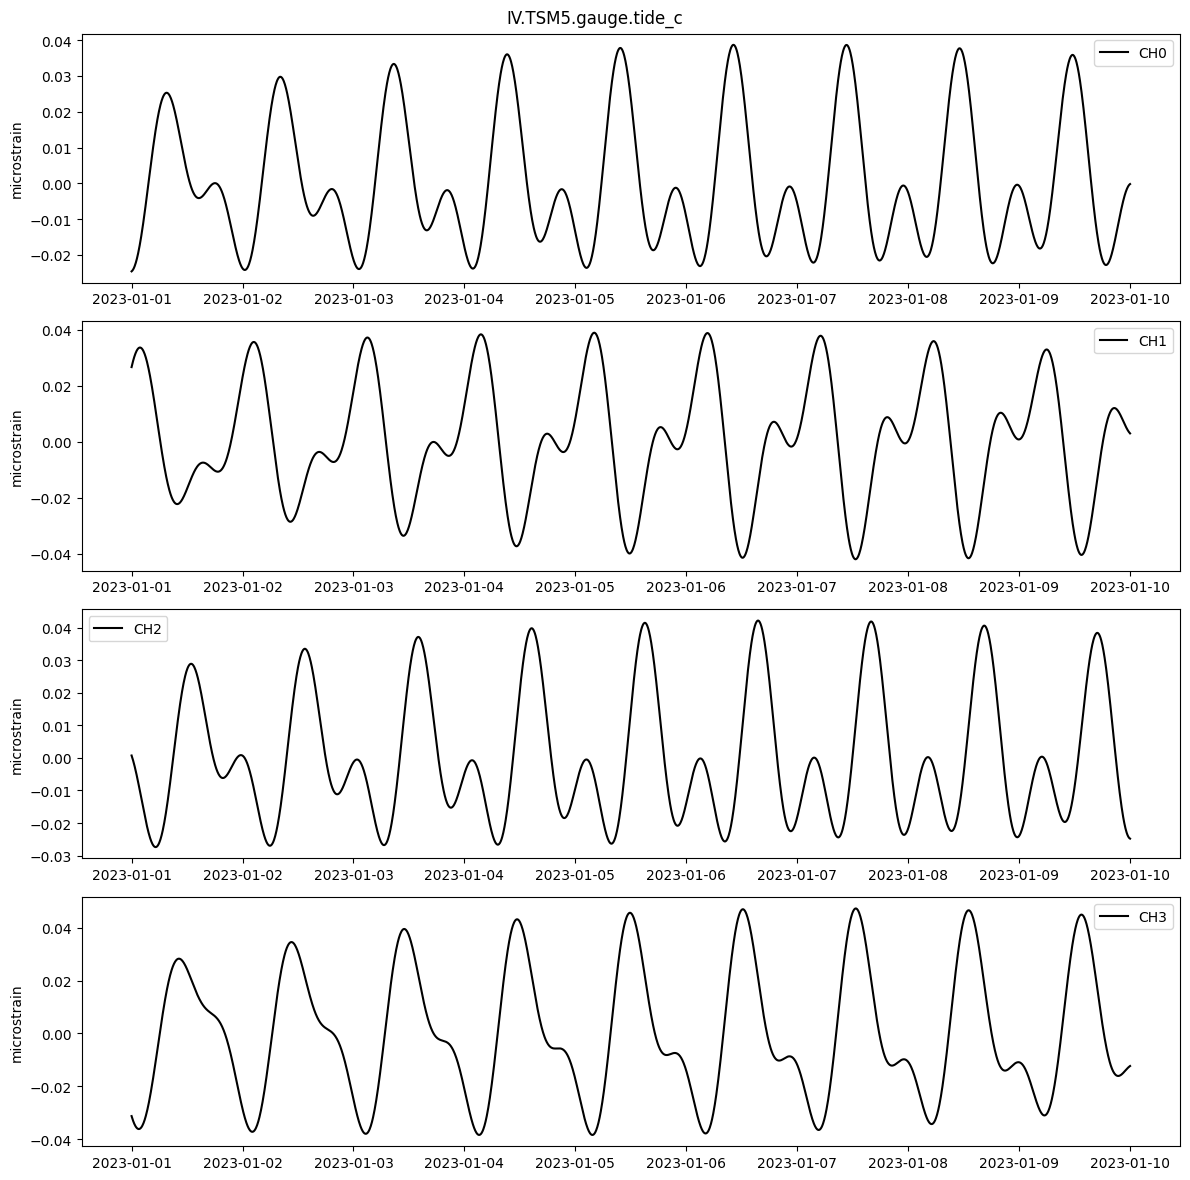

In [130]:
# This step will run a docker container of SPOTL (https://igppweb.ucsd.edu/~agnew/Spotl/spotlmain.html) to calculate the tides. 
# If docker is not running on your computer, start docker.
name = f"{network}.{station}.gauge.tide_c"
tide_c = gauge_microstrain.calculate_tide_correction(tidal_parameters=meta.tidal_params, longitude=meta.longitude, name=name)
tide_c.plot()
#tide_corrected = gauge_microstrain.apply_corrections([tide_c])
#plot_timeseries_comparison([gauge_microstrain, tide_corrected], names=['uncorrected', 'atmp_corrected'], zero=True)

### Atmospheric Pressure <a class="anchor" id="pressure"></a>

An atmospheric pressure correction coefficient, similar to the tidal constituents, was likewise calculated for each gauge in BAYTAP08. This coefficient is multiplied by the colocated surface barometric pressure sensor data to calculate a pressure correction time series. Note that many stations have pressure data at a sample period of 30 minutes, while some have 1 sps data available. In the case of 30 minute data, the correction can be linearly interpolated to the time series of interest.

IV TSM5 Loading * RDO from 2023-01-01T00:00:00 to 2023-01-10T00:00:00 from Earthscope DMC miniseed
    Trace 1. 2023-01-01T00:00:00.000000Z:2023-01-10T00:00:00.000000Z mapping RDO to atmp
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Converting missing data from 999999 to nan
  Converting 999999 values to nan
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Interpolating data using method=linear and limit=3600
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Calculating pressure correction
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


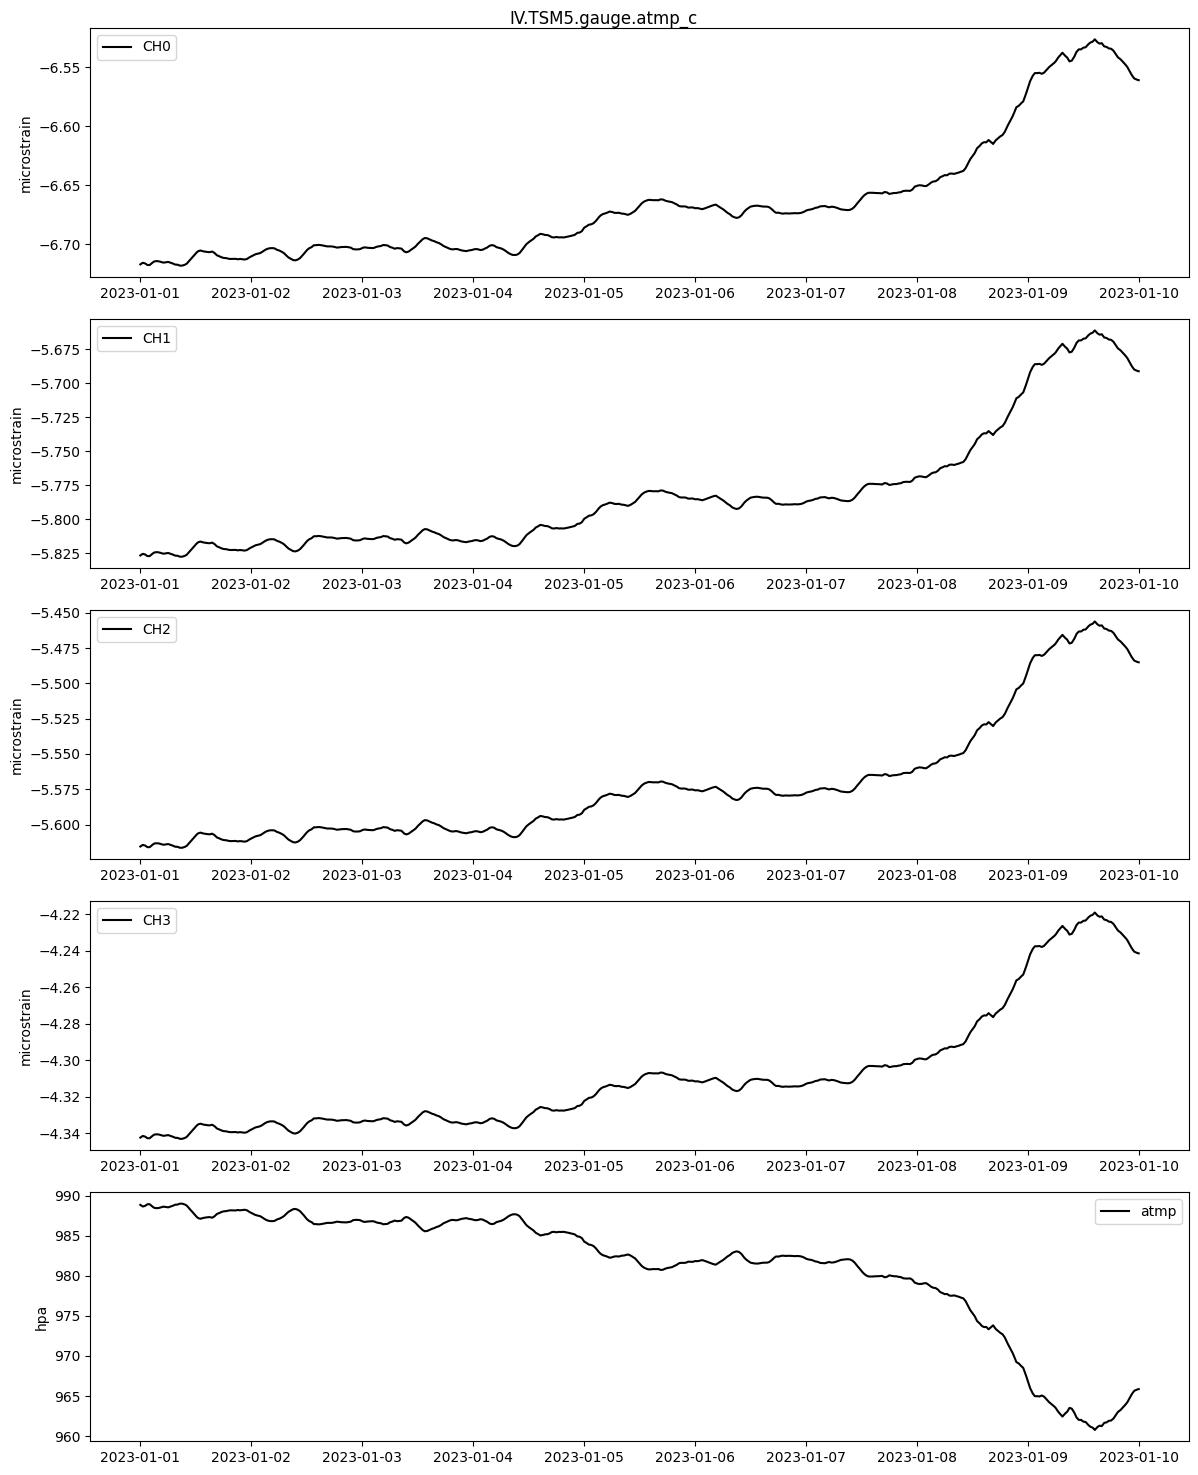

In [131]:
# Acquire pressure data, calculate and plot the correction

# Pressure data from miniseed
# note that channel code for 1 sps data, if available, is 'LDO'
atmp_raw = ts_from_mseed(network=network, station=station, location='*', channel='RDO', 
                        start=start, end=end, period=60*30, scale_factor=0.001, units='hpa')
# Interpolate the pressure data to the same time as the strain data
atmp = atmp_raw.interpolate(new_index=strain_raw.data.index, series='hpa')

# Calculate and plot the correction
name = f"{network}.{station}.gauge.atmp_c"
atmp_c = atmp.calculate_pressure_correction(meta.atmp_response, name=name)
atmp_c.plot(atmp=atmp)
# Plot the corrected time series comparison if desired
#atmp_corrected = gauge_microstrain.apply_corrections([atmp_c])
#atmp_corrected.plot()
#plot_timeseries_comparison([gauge_microstrain, atmp_corrected], names=['uncorrected', 'atmp_corrected'], zero=True)


### Offsets <a class="anchor" id="offsets"></a>

Offsets in this section are automatically detected via a simple first differencing algorithm. The best approach is to first correct for other known changes (tides, pressure, trend), then to apply the ```calculate_offsets``` function. This function finds jumps between consecutive datapoints that are above a cutoff limit, which is assigned from a user-specified value multiplied by a user-specified percentile of all first differences calculated for the gauge. For example, if a multiplier of 10 and percentile of 75% are used on a dataset whose first difference 75th percentile is 2 nanostrain, any jump in the data above 20 nanostrain will be flagged as an offset. This method is not perfect, but works well for certain situations. 

Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Calculating offsets using cutoff percentile of 75 and limit multiplier of 5.
Using offset limits of [0.002407, 0.001259, 0.001481, 0.001123]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


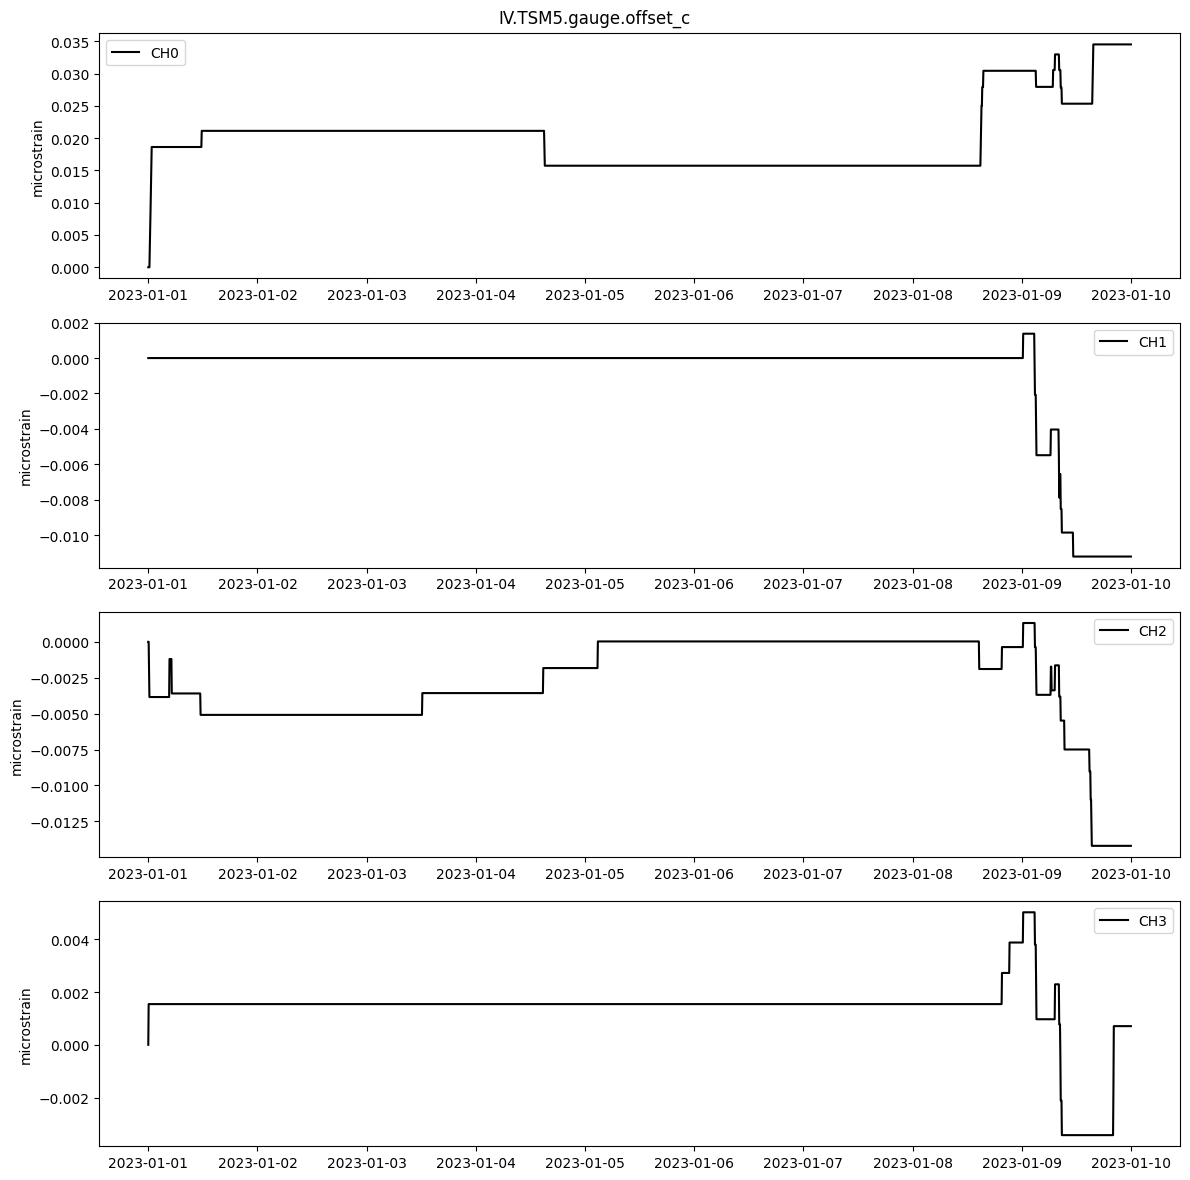

In [132]:
# Calculate offset correction on data that has been corrected for tides, trend, and pressure
name = f"{network}.{station}.gauge.offset_c"
pre_offset_corrected = gauge_microstrain.apply_corrections([tide_c,trend_c]) #, atmp_c])
offset_c = pre_offset_corrected.calculate_offsets(limit_multiplier=5,cutoff_percentile=75,name=name)
offset_c.plot()

### Plot corrections

Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


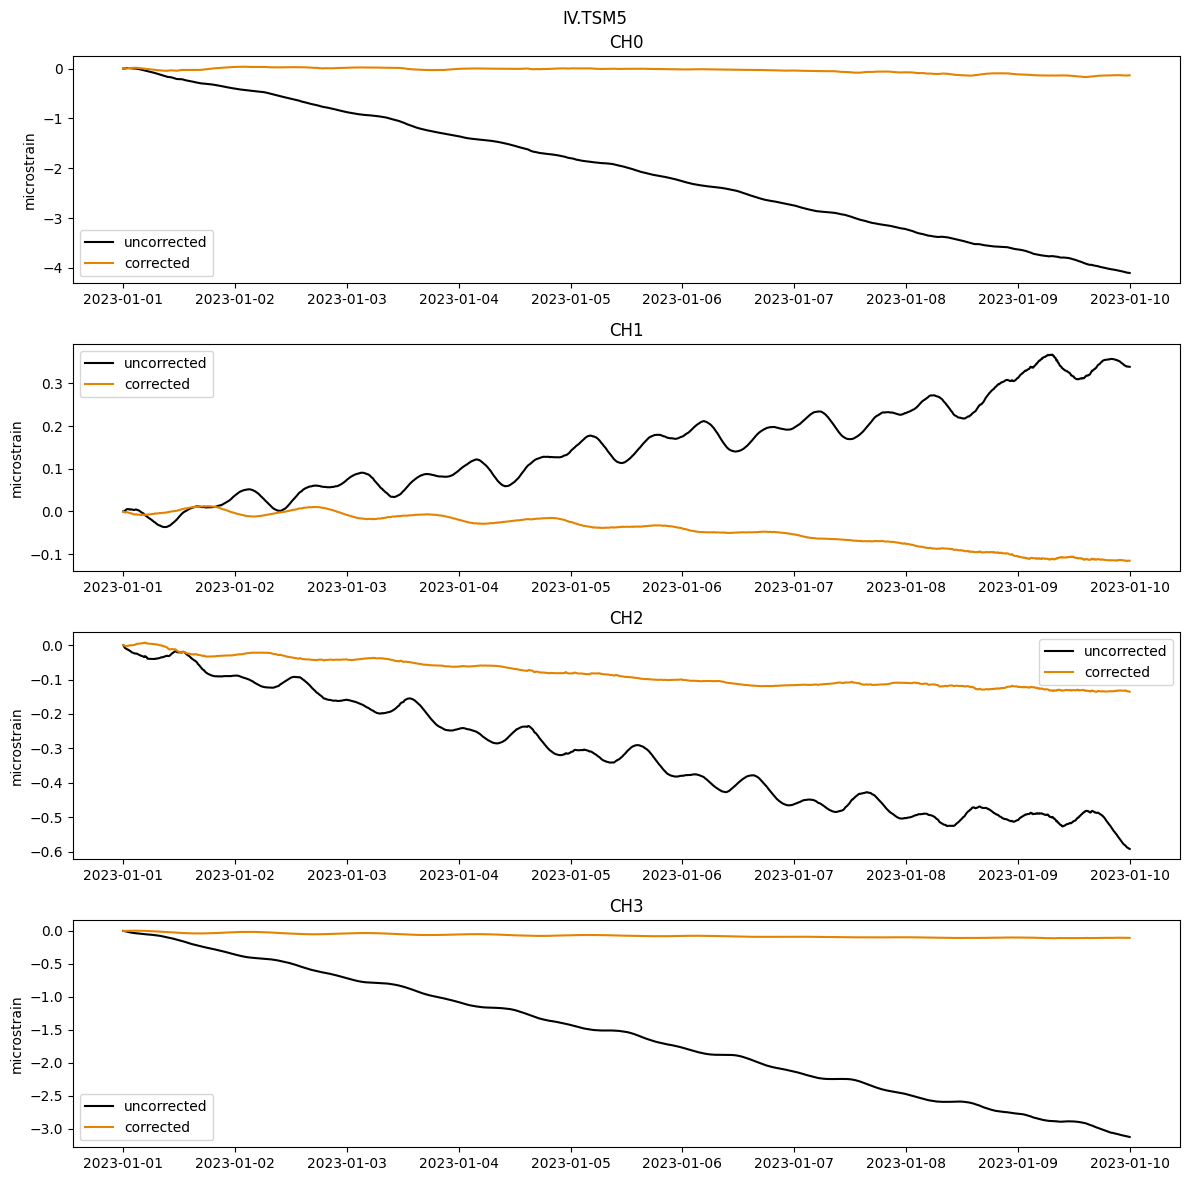

In [133]:
title=f"{network}.{station}"
gauge_corrected = gauge_microstrain.apply_corrections([tide_c, atmp_c, offset_c, trend_c])
plot_timeseries_comparison([gauge_microstrain, gauge_corrected], title=title, names=['uncorrected', 'corrected'], zero=True)

### Regional Strain Conversion <a class="anchor" id="regionals"></a>

The strain from each individual gauge represents the whole instrument, grout, and bedrock response to strain. Most geophysical applications are interested in only the value of rock formation strain. To this end, we apply a calibration (or orientation) matrix to the four gauge strains that transforms the recorded gauge strains into regional areal, differential shear, and engineering shear strains in the East/North reference system. 

Various methods for calibration have been completed, and the background information in the docs provides references if you'd like to learn more about each type of calibration. All stations have a 'lab' orientation matrix, which relies on accurate installation orientations for the gauges, equal gauge sensitivities, isotropic and homogeneous rock conditions, and rock strength comparable to that of granite (Hodgkinson et al., 2013). Regional strains can also be achieved through tidal calibration, which compares the observed tidal signal to predicted, approximately well-known tidal signal. Tidal calibrations are available for several stations from calibrations completed by geoscience community members (Hanagan et al., In Prep; Hodgkinson et al., 2013; Roeloffs et al., 2010). The best calibration should be assesed on an individual station basis. 

In [134]:
# Which orientation matrices are available for the station?
meta.strain_matrices

{'lab': array([[ 0.2962963 ,  0.51851852,  0.2962963 ,  0.22222222],
        [-0.23421081,  0.3334514 ,  0.10083025, -0.20007084],
        [-0.31429352, -0.1611967 ,  0.3787722 ,  0.09671802]]),
 'ER2010': None,
 'CH_prelim': array([[-2.08608359, -2.03266363, -1.68423953, -0.55516656],
        [-0.17007719,  0.21162844,  0.28758364, -0.11504928],
        [-0.4530047 , -0.43650645,  0.00835573,  0.03031218]])}

Applying None matrix: [[-2.08608359 -2.03266363 -1.68423953 -0.55516656]
 [-0.17007719  0.21162844  0.28758364 -0.11504928]
 [-0.4530047  -0.43650645  0.00835573  0.03031218]]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
IV.TSM5.gauge.microstrain.calibrated
    | Channels: ['Eee+Enn', 'Eee-Enn', '2Ene']           
    | TimeRange: 2023-01-01 00:00:00 - 2023-01-10 00:00:00        | Period:           300s
    | Series: microstrain| Units:   microstrain| Level:         2a| Gaps:             0.0% 
    | Epochs:        2593| Good:         2593.0| Missing:      0.0| Interpolated:      0.0
    | Samples:       7779| Good:           7779| Missing:        0| Interpolated:        0


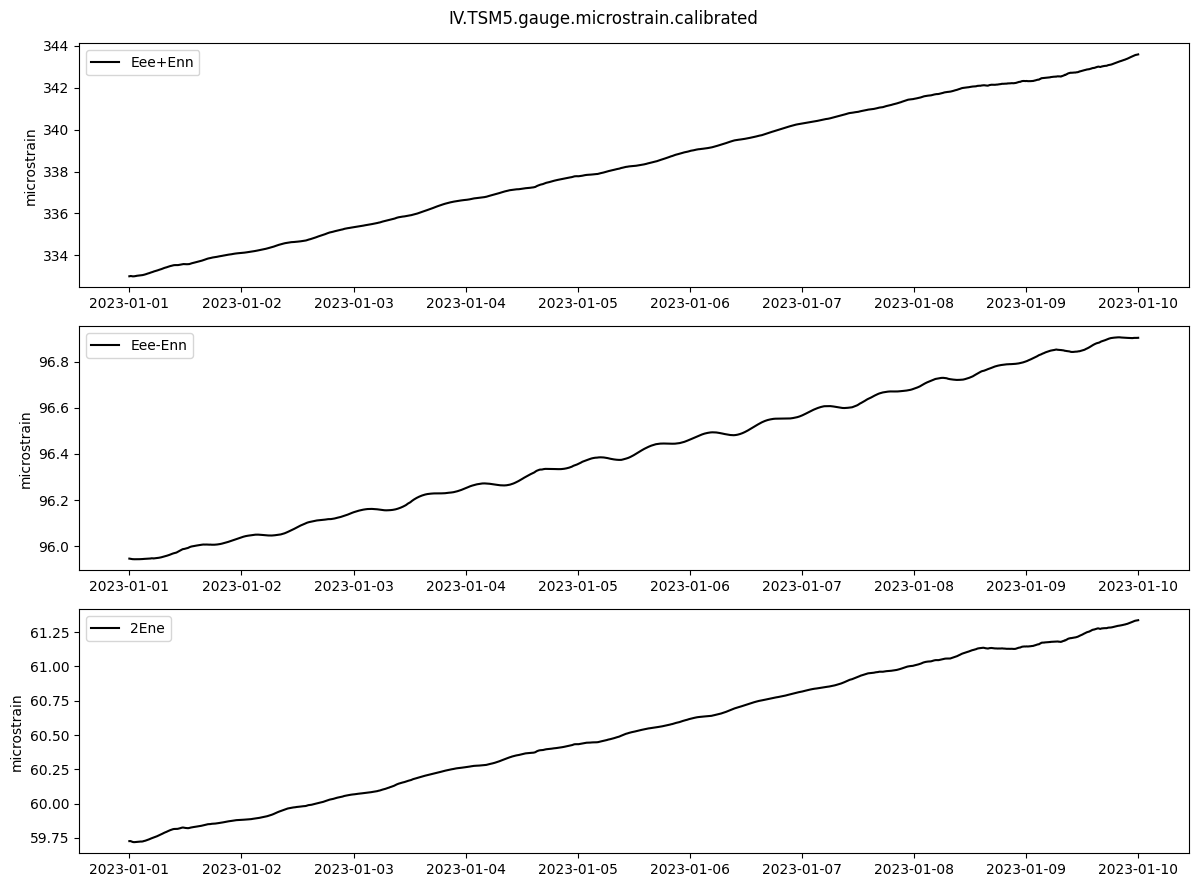

In [135]:
# Choose calibration matrix and calculare regional strains
calibration_matrix = meta.strain_matrices['CH_prelim']
regional_microstrain = gauge_microstrain.apply_calibration_matrix(calibration_matrix)
regional_microstrain.stats()
regional_microstrain.plot()

In [136]:
# Calculate regional strain corrections
regional_tide_c = tide_c.apply_calibration_matrix(calibration_matrix)
regional_trend_c = trend_c.apply_calibration_matrix(calibration_matrix)
regional_atmp_c = atmp_c.apply_calibration_matrix(calibration_matrix)
regional_offset_c = offset_c.apply_calibration_matrix(calibration_matrix)


Applying None matrix: [[-2.08608359 -2.03266363 -1.68423953 -0.55516656]
 [-0.17007719  0.21162844  0.28758364 -0.11504928]
 [-0.4530047  -0.43650645  0.00835573  0.03031218]]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying None matrix: [[-2.08608359 -2.03266363 -1.68423953 -0.55516656]
 [-0.17007719  0.21162844  0.28758364 -0.11504928]
 [-0.4530047  -0.43650645  0.00835573  0.03031218]]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying None matrix: [[-2.08608359 -2.03266363 -1.68423953 -0.55516656]
 [-0.17007719  0.21162844  0.28758364 -0.11504928]
 [-0.4530047  -0.43650645  0.00835573  0.03031218]]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying None matrix: [[-2.08608359 -2.03266363 -1.68423953 -0.55516656]
 [-0.17007719  0.21162844  0.28758364 -0.11504928]
 [-0.4530047  -0.4365064

Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


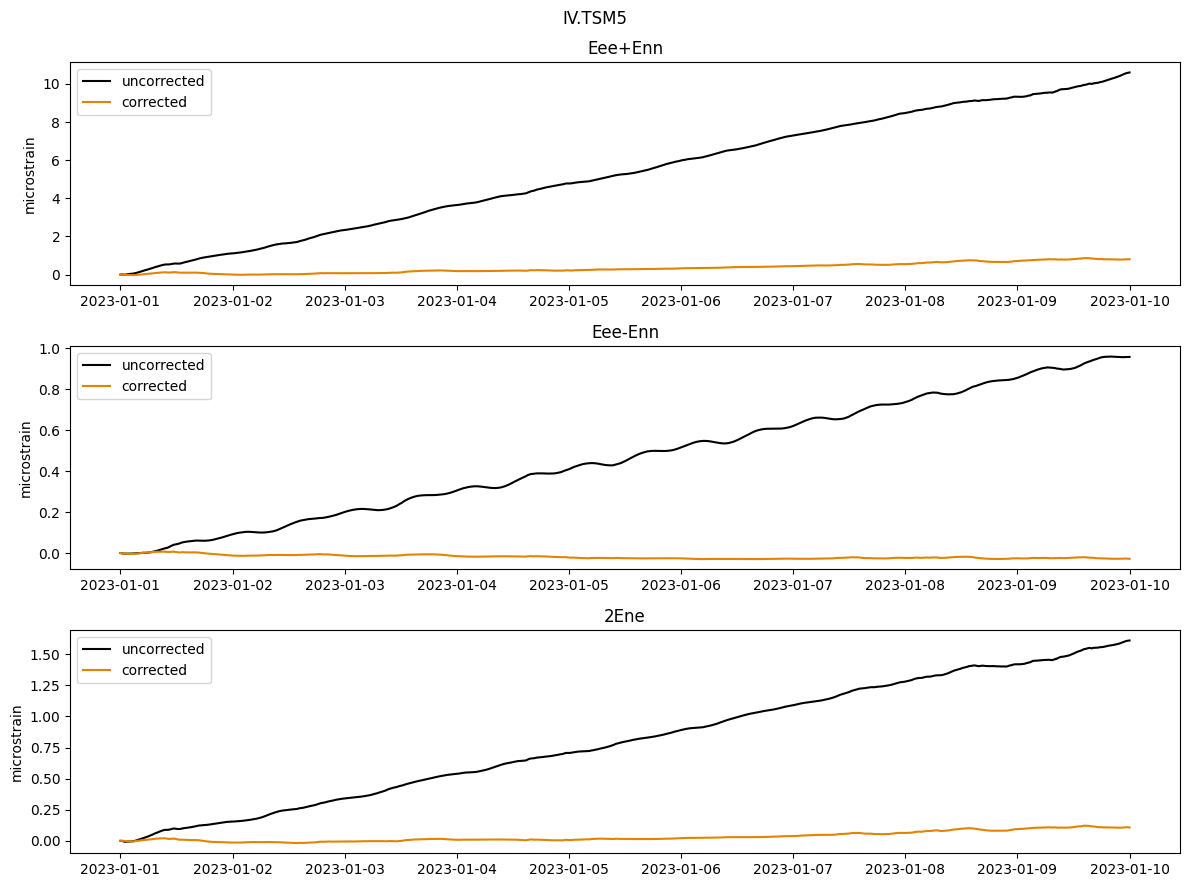

In [137]:
# Plot regional strains
title=f"{network}.{station}"
regional_corrected = regional_microstrain.apply_corrections([regional_tide_c, regional_atmp_c, regional_offset_c, regional_trend_c])
plot_timeseries_comparison([regional_microstrain, regional_corrected], title=title, names=['uncorrected', 'corrected'], zero=True)

## Additional Comparisons: <a class="anchor" id="additional"></a>

**Plot corrected data with other environmental data**

Rainfall and more general water level changes can induce strain changes. Rain gauges at all stations, and pore pressure transducers at some stations, provide useful hyrologic information for comparison to the strain time series. 

IV TSM5 Loading * RRO from 2023-01-01T00:00:00 to 2023-01-10T00:00:00 from Earthscope DMC miniseed
    Trace 1. 2023-01-01T00:00:00.000000Z:2023-01-10T00:00:00.000000Z mapping RRO to rain
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Converting missing data from 999999 to nan
  Converting 999999 values to nan
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
IV.TSM5.gauge.microstrain.calibrated.corrected
    | Channels: ['Eee+Enn', 'Eee-Enn', '2Ene']           
    | TimeRange: 2023-01-01 00:00:00 - 2023-01-10 00:00:00        | Period:           300s
    | Series:   corrected| Units:   microstrain| Level:         2a| Gaps:             0.0% 
    | Epochs:        2593| Good:         2593.0| Missing:      0.0| Interpolated:      0.0
    | Samples:       7779| Good:           7779| Missing:        0| Interpolated:        0


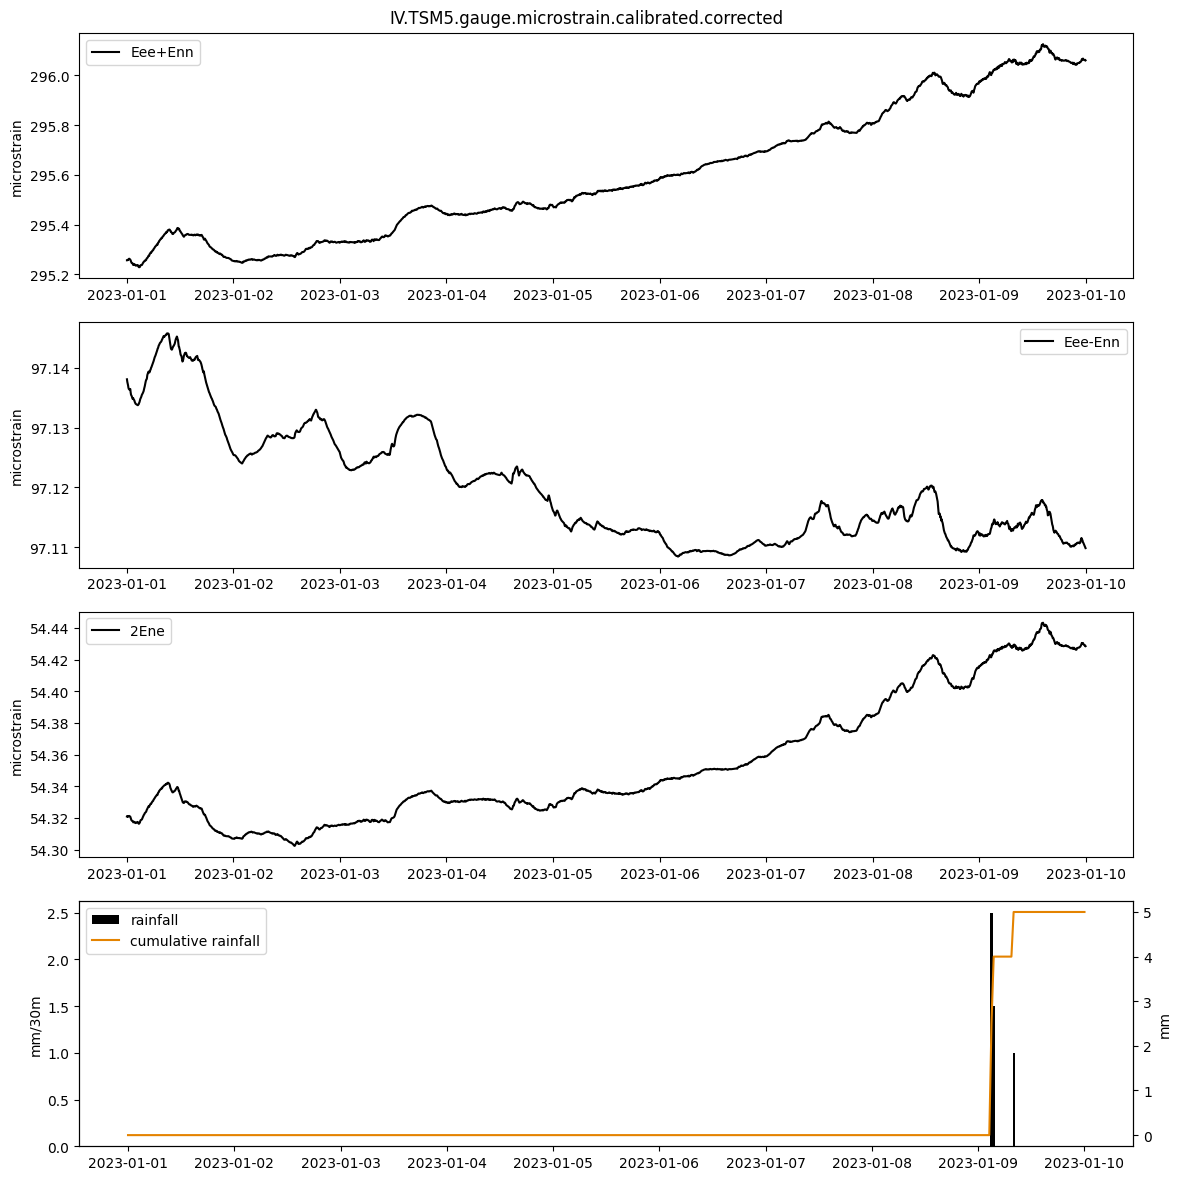

In [138]:
# Get rain data and convert to units of mm per 30 minute sample period
rainfall = ts_from_mseed(network=network, station=station, location='*', channel='RRO', 
                         start=start, end=end, period=60*30, scale_factor=0.0001, units='mm/30m')
regional_corrected.plot(rainfall=rainfall)
regional_corrected.stats()